In [1]:
# 📓 Mejora de clustering de reservas hoteleras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
# 1. Carga de datos
# Reemplazar con tu ruta real al CSV
ruta_csv = "../src/data/raw/hotel_bookings.csv"
df = pd.read_csv(ruta_csv)

In [3]:
# 2. Ingeniería de features clave
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

features = [
    "lead_time", "total_nights", "adults", "children", "babies",
    "previous_cancellations", "booking_changes", "adr"
]

X = df[features].copy().fillna(0)

In [5]:
# 3. Evaluación de k óptimo
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scores = []
for k in range(2, 10):
    model = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append((k, score))
    print(f"k={k} → Silhouette: {score:.4f}")

k=2 → Silhouette: 0.4925
k=3 → Silhouette: 0.4529
k=4 → Silhouette: 0.4592
k=5 → Silhouette: 0.2549
k=6 → Silhouette: 0.2653
k=7 → Silhouette: 0.2742
k=8 → Silhouette: 0.2937
k=9 → Silhouette: 0.2791


In [6]:
# 4. Escalado y clustering con el mejor k manual
k_best = 2
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=k_best, random_state=42, n_init=20))
])

pipeline.fit(X)
df["cluster"] = pipeline.named_steps["kmeans"].labels_

In [8]:
# 5. Evaluación del clustering
score = silhouette_score(X_scaled, df["cluster"])
print(f"Silhouette score final con k={k_best}: {score:.4f}")

Silhouette score final con k=2: 0.4925


In [9]:
# 6. Análisis por cluster
cluster_summary = df.groupby("cluster")[features].mean()
distribucion = df["cluster"].value_counts(normalize=True).rename("%") * 100

print("\nDistribución de clusters:")
print(distribucion.round(2))
print("\nCentroides por cluster:")
print(cluster_summary.round(2))



Distribución de clusters:
cluster
1    92.2
0     7.8
Name: %, dtype: float64

Centroides por cluster:
         lead_time  total_nights  adults  children  babies  \
cluster                                                      
0            89.32          3.99    2.00      1.32     0.1   
1           105.25          3.38    1.84      0.00     0.0   

         previous_cancellations  booking_changes     adr  
cluster                                                   
0                          0.01             0.43  156.17  
1                          0.09             0.20   97.24  


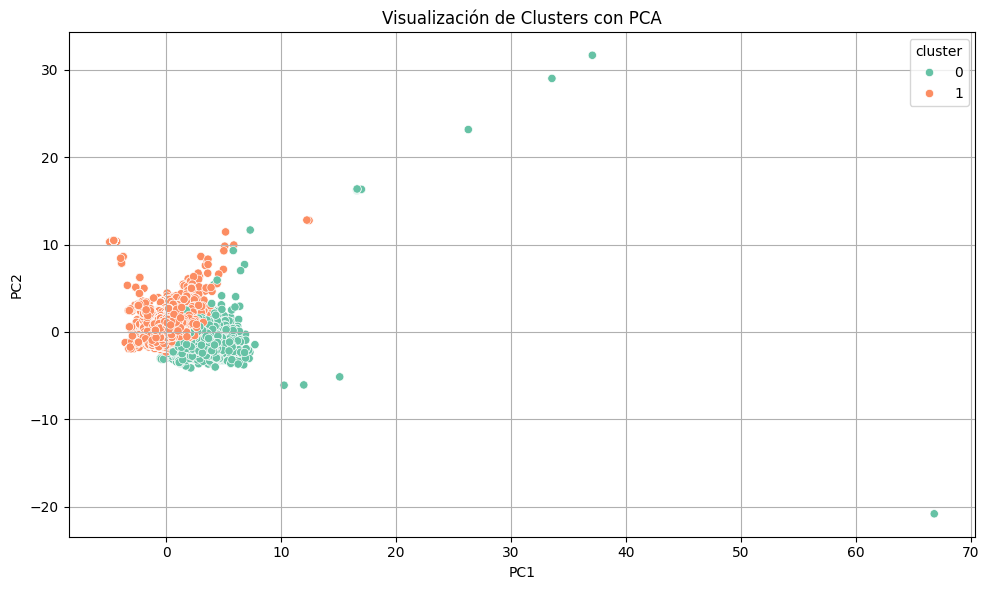

In [10]:
# 7. Visualización con PCA
scaler = pipeline.named_steps["scaler"]
kmeans = pipeline.named_steps["kmeans"]

X_scaled = scaler.transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["cluster"], palette="Set2")
plt.title("Visualización de Clusters con PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Mostrar características promedio por cluster
pd.options.display.float_format = '{:,.2f}'.format
summary = df.groupby("cluster")[features].mean().round(2)
print(summary)


In [13]:
# 8. Guardado del modelo y scaler
import joblib
joblib.dump(pipeline.named_steps["kmeans"], "../src/model/kmeans_model.pkl")
joblib.dump(pipeline.named_steps["scaler"], "../src/model/scaler.pkl")

['../src/model/scaler.pkl']